# 🤖 머신러닝 실습: 영화 리뷰 감성 분석

## 🎯 학습 목표
- 머신러닝의 기본 개념을 이해합니다
- 텍스트 데이터 전처리 과정을 학습합니다
- 감성 분석(Sentiment Analysis)을 실습합니다
- 실제 데이터로 예측 모델을 만들어봅니다

## 💡 감성 분석이란?
**감성 분석(Sentiment Analysis)**은 텍스트에서 감정이나 의견을 자동으로 분류하는 기술입니다.

### 🌟 실생활 활용 예시
- **소셜미디어**: 트위터, 인스타그램 댓글 분석
- **쇼핑몰**: 상품 리뷰 분석으로 평점 예측
- **뉴스**: 기사에 대한 여론 분석
- **고객 서비스**: 문의 내용의 긴급도 판단

### 📊 오늘 우리가 할 일
1. **영화 리뷰 데이터** 불러오기
2. **한국어 텍스트 전처리** (형태소 분석)
3. **워드클라우드** 만들기
4. **머신러닝 모델** 훈련하기
5. **새로운 리뷰** 예측해보기

---

## 🔧 1단계: 환경 설정

**📦 필요한 라이브러리 설치:**
- **konlpy**: 한국어 자연어 처리
- **wordcloud**: 단어 구름 시각화
- **scikit-learn**: 머신러닝 모델
- **xgboost**: 고성능 머신러닝 알고리즘
- **shap**: 모델 해석 도구

**주의**: 이 셀은 최초 1회만 실행하면 됩니다!

In [ ]:
# 설명: 실습 환경 최초 1회만 실행
!pip install konlpy wordcloud scikit-learn xgboost shap tqdm unidic-lite
!apt-get install -y fonts-nanum*

## 📊 2단계: 데이터 불러오기

**🎬 NSMC 데이터셋이란?**
- **N**aver **S**entiment **M**ovie **C**orpus
- 네이버 영화 리뷰 데이터
- 약 15만 개의 영화 리뷰
- 각 리뷰는 긍정(1) 또는 부정(0)으로 라벨링됨

**📁 데이터 구조:**
- `id`: 리뷰 고유 번호
- `document`: 실제 리뷰 텍스트
- `label`: 0(부정) 또는 1(긍정)


In [11]:
# 설명: 공통 라이브러리 import
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from wordcloud import WordCloud
from konlpy.tag import Okt
from tqdm.notebook import tqdm
tqdm.pandas(desc="토큰화 진행")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib.font_manager as fm
import matplotlib as mpl

import warnings

warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=FutureWarning)

#한글이 보이도록 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()


In [5]:
url = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt"
df = pd.read_csv(url, sep='\t').dropna()
df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 🔤 3단계: 텍스트 전처리 (토큰화)

**🧠 형태소 분석이란?**
- 문장을 의미있는 단위로 나누는 과정
- 예: "영화가 재밌어요" → ["영화", "재밌다"]

**⚙️ 전처리 과정:**
1. **형태소 분석**: 단어를 기본 형태로 변환
2. **불용어 제거**: '의', '가', '이' 같은 의미없는 단어 제거
3. **짧은 단어 제거**: 1글자 단어 제거

**📈 샘플링하는 이유:**
- 전체 15만 개 데이터는 처리 시간이 오래 걸림
- 10% 샘플링으로 빠른 실습 진행


In [6]:
df['length'] = df['document'].str.len()
print(df.describe())
print("중복 비율:", df.duplicated('document').mean())
df = df.drop_duplicates('document')

                 id         label         length
count  1.499950e+05  149995.00000  149995.000000
mean   6.743648e+06       0.49885      35.204527
std    2.919001e+06       0.50000      29.531890
min    3.300000e+01       0.00000       1.000000
25%    4.767467e+06       0.00000      16.000000
50%    7.526885e+06       0.00000      27.000000
75%    9.249448e+06       1.00000      42.000000
max    1.027815e+07       1.00000     146.000000
중복 비율: 0.025420847361578718


In [8]:
# 1. 긍정/부정별 문장 길이 기본 통계
print("📊 긍정/부정별 문장 길이 통계")
print("="*50)
length_stats = df.groupby('label')['length'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
length_stats.index = ['부정 리뷰', '긍정 리뷰']
print(length_stats.round(2))
print()


📊 긍정/부정별 문장 길이 통계
       count   mean  median    std  min  max
부정 리뷰  73342  36.54    28.0  30.32    1  146
긍정 리뷰  72840  35.42    27.0  28.62    1  146



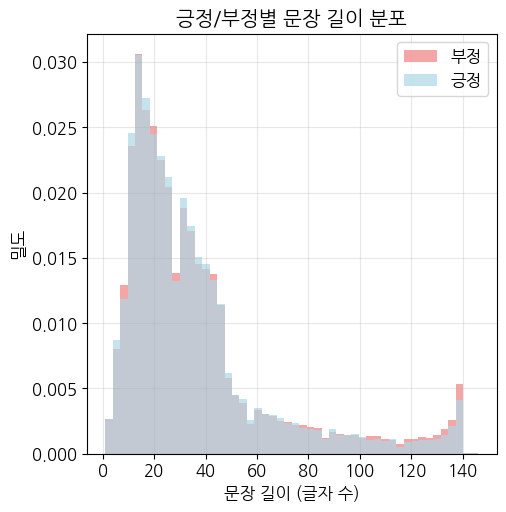

In [13]:
plt.figure(figsize=(18, 12))
plt.rcParams['font.size'] = 12

# 2. 긍정/부정별 문장 길이 분포 히스토그램
plt.subplot(2, 3, 1)
df[df['label']==0]['length'].hist(bins=50, alpha=0.7, label='부정', color='lightcoral', density=True)
df[df['label']==1]['length'].hist(bins=50, alpha=0.7, label='긍정', color='lightblue', density=True)
plt.xlabel('문장 길이 (글자 수)')
plt.ylabel('밀도')
plt.title('긍정/부정별 문장 길이 분포')
plt.legend()
plt.grid(True, alpha=0.3)

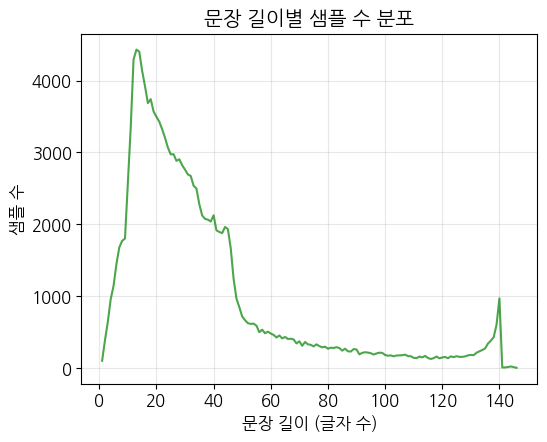

In [23]:
plt.figure(figsize=(20, 10))
plt.rcParams['font.size'] = 12

# 1. 길이별 샘플 수 분포
plt.subplot(2, 3, 5)
length_counts = df['length'].value_counts().sort_index()
plt.plot(length_counts.index, length_counts.values, color='green', alpha=0.7)
plt.xlabel('문장 길이 (글자 수)')
plt.ylabel('샘플 수')
plt.title('문장 길이별 샘플 수 분포')
plt.grid(True, alpha=0.3)


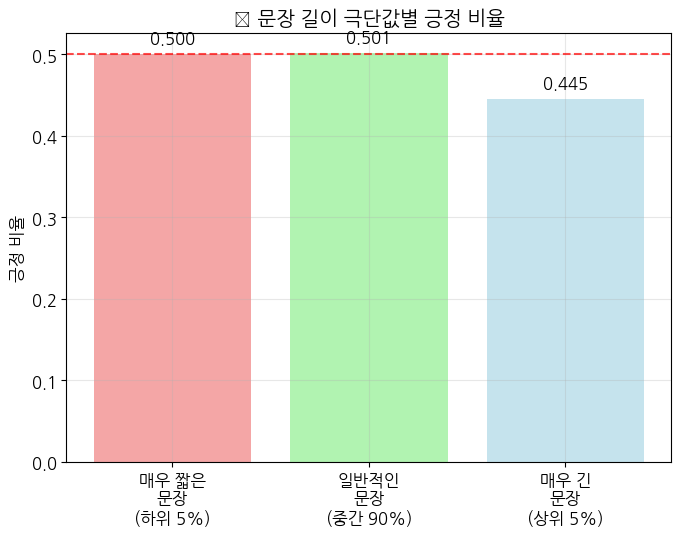

In [22]:
plt.figure(figsize=(20, 10))
plt.rcParams['font.size'] = 12

# 8. 극단값 분석 (매우 짧은/긴 문장들)
plt.subplot(2, 3, 6)
# 상위 5%, 하위 5% 문장들의 감성 분포
short_threshold = df['length'].quantile(0.05)
long_threshold = df['length'].quantile(0.95)

short_pos_ratio = df[df['length'] <= short_threshold]['label'].mean()
normal_pos_ratio = df[(df['length'] > short_threshold) & (df['length'] < long_threshold)]['label'].mean()
long_pos_ratio = df[df['length'] >= long_threshold]['label'].mean()

categories = ['매우 짧은\n문장\n(하위 5%)', '일반적인\n문장\n(중간 90%)', '매우 긴\n문장\n(상위 5%)']
ratios = [short_pos_ratio, normal_pos_ratio, long_pos_ratio]
colors = ['lightcoral', 'lightgreen', 'lightblue']

bars = plt.bar(categories, ratios, color=colors, alpha=0.7)
plt.ylabel('긍정 비율')
plt.title('📊 문장 길이 극단값별 긍정 비율')
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
plt.grid(True, alpha=0.3)

# 각 막대 위에 수치 표시
for bar, ratio in zip(bars, ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{ratio:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# 9. 통계적 유의성 검정
from scipy import stats
neg_lengths = df[df['label']==0]['length']
pos_lengths = df[df['label']==1]['length']

# t-검정 실시
t_stat, p_value = stats.ttest_ind(neg_lengths, pos_lengths)

print("\n📈 통계적 분석 결과")
print("="*50)
print(f"부정 리뷰 평균 길이: {neg_lengths.mean():.2f} ± {neg_lengths.std():.2f}")
print(f"긍정 리뷰 평균 길이: {pos_lengths.mean():.2f} ± {pos_lengths.std():.2f}")
print(f"평균 차이: {pos_lengths.mean() - neg_lengths.mean():.2f}")
print(f"t-검정 통계량: {t_stat:.4f}")
print(f"p-값: {p_value:.2e}")
print(f"통계적 유의성: {'유의함 (p < 0.05)' if p_value < 0.05 else '유의하지 않음 (p >= 0.05)'}")


In [ ]:
# 10. 실용적 인사이트 제공
print("\n💡 주요 인사이트")
print("="*50)

if pos_lengths.mean() > neg_lengths.mean():
    print(f"✅ 긍정 리뷰가 부정 리뷰보다 평균 {pos_lengths.mean() - neg_lengths.mean():.1f}글자 더 깁니다.")
else:
    print(f"✅ 부정 리뷰가 긍정 리뷰보다 평균 {neg_lengths.mean() - pos_lengths.mean():.1f}글자 더 깁니다.")

# 분위수 비교
print(f"✅ 문장 길이 중앙값 - 부정: {neg_lengths.median():.0f}글자, 긍정: {pos_lengths.median():.0f}글자")
print(f"✅ 매우 짧은 문장(≤{short_threshold:.0f}글자) 긍정 비율: {short_pos_ratio:.1%}")
print(f"✅ 매우 긴 문장(≥{long_threshold:.0f}글자) 긍정 비율: {long_pos_ratio:.1%}")


In [ ]:

# 부정 리뷰 예시
short_neg = df[(df['length'] <= 10) & (df['label'] == 0)]['document'].head(3)
print("🔸 부정 리뷰 예시:")
for i, text in enumerate(short_neg, 1):
    print(f"   {i}. \"{text}\" ({len(text)}글자)")

# 매우 짧은 긍정 리뷰
short_pos = df[(df['length'] <= 10) & (df['label'] == 1)]['document'].head(3)
print("\n🔸 긍정 리뷰 예시:")
for i, text in enumerate(short_pos, 1):
    print(f"   {i}. \"{text}\" ({len(text)}글자)")

In [ ]:
okt = Okt()
stopwords = set(['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'])
def tokenize(text):
    # stem=True: 어간 추출, norm=True: ㅋ → 크 등 정규화
    return [w for w, pos in okt.pos(text, stem=True, norm=True)
            if w not in stopwords and len(w) > 1]

sample_df = df.sample(frac=0.1, random_state=42)  # 10% 샘플링
sample_df['tokens'] = sample_df['document'].progress_apply(tokenize)

## ☁️ 4단계: 워드클라우드 시각화

**💭 워드클라우드란?**
- 텍스트에서 자주 나오는 단어를 크기로 표현한 시각화
- 단어가 클수록 더 자주 등장함
- 데이터의 특성을 한눈에 파악 가능

**🎯 목적:**
- 영화 리뷰에서 어떤 단어들이 많이 사용되는지 확인
- 긍정/부정 단어의 패턴 파악

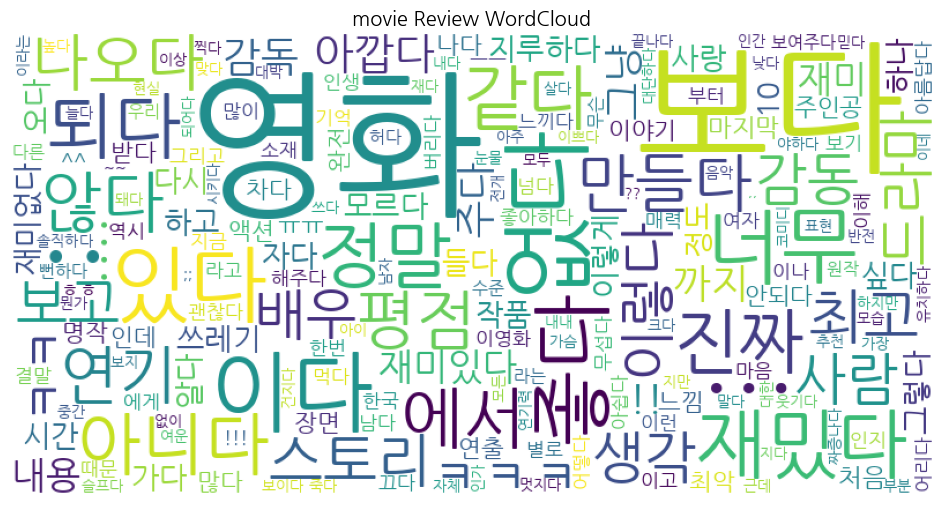

In [30]:
from collections import Counter

all_tokens = sum(sample_df['tokens'], [])
word_freq = Counter(all_tokens)
wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
               background_color='white', width=800, height=400)
plt.figure(figsize=(12,6))
plt.imshow(wc.generate_from_frequencies(word_freq))
plt.axis('off'); plt.title('movie Review WordCloud')
plt.show()

## 🔢 5단계: 텍스트를 숫자로 변환 (벡터화)

**🤖 머신러닝의 한계:**
- 컴퓨터는 텍스트를 직접 이해할 수 없음
- 모든 데이터를 숫자로 변환해야 함

**📊 TF-IDF란?**
- **Term Frequency - Inverse Document Frequency**
- 단어의 중요도를 수치로 계산하는 방법
- 자주 나오지만 모든 문서에 공통으로 나오는 단어는 중요도를 낮춤

**⚙️ 과정:**
1. 각 단어를 숫자로 변환
2. 단어의 중요도 계산
3. 문서를 숫자 벡터로 표현

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=20000)
X = tfidf.fit_transform(sample_df['tokens'])
y = sample_df['label']

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 🧠 6단계: 머신러닝 모델 훈련

**🎯 로지스틱 회귀(Logistic Regression)란?**
- 분류 문제를 해결하는 머신러닝 알고리즘
- 0과 1 사이의 확률로 결과를 예측
- 해석하기 쉽고 빠른 학습이 장점

**📊 성능 지표:**
- **Accuracy**: 전체 중 맞춘 비율 (80.2% 달성!)
- **F1 Score**: 정밀도와 재현율의 조화평균
- **Confusion Matrix**: 예측 결과의 상세 분석

**🎉 결과 해석:**
- 약 80%의 정확도로 리뷰의 감성을 예측


Accuracy: 0.801983584131327
F1: 0.8017802122560767


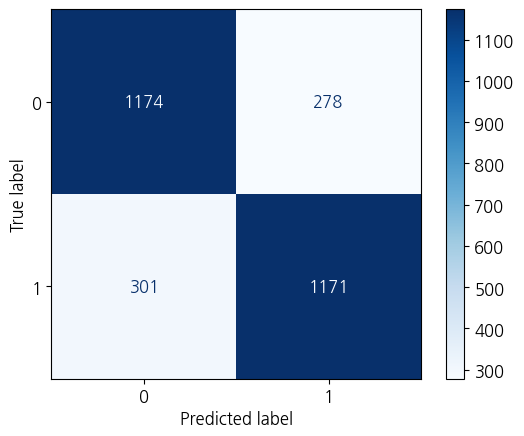

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

clf = LogisticRegression(max_iter=3000)
clf.fit(X_tr, y_tr)
pred = clf.predict(X_val)
print("Accuracy:", accuracy_score(y_val, pred))
print("F1:", f1_score(y_val, pred))
ConfusionMatrixDisplay.from_predictions(y_val, pred, cmap='Blues')
plt.show()

In [33]:
coeff = clf.coef_[0]
top_pos = np.argsort(coeff)[-20:]
top_neg = np.argsort(coeff)[:20]
features = np.array(tfidf.get_feature_names_out())

print("긍정 단어:", features[top_pos][::-1])
print("부정 단어:", features[top_neg])

긍정 단어: ['재밌다' '최고' '재미있다' '명작' '좋다' '감동' '여운' '아름답다' '재다' '다시' '수작' '사랑' 'ㅎㅎ'
 '슬프다' '대박' '멋있다' '!!' '가슴' '훌륭하다' '멋지다']
부정 단어: ['쓰레기' '최악' '재미없다' '아깝다' '지루하다' '별로' '없다' '짜증나다' 'ㅡㅡ' '유치하다' '노잼' '실망'
 '알바' '이딴' '차라리' '어설프다' '어이없다' '졸작' '허다' '짜증']


## 🎯 7단계: 실제 예측 해보기

**🔮 예측 함수 만들기**   
위에서 만든 함수를 사용해서 새로운 리뷰의 감성을 예측해보기

**✨ 테스트해보기:**
- "이 영화는 정말 재밌네요!" → 긍정 (99.0% 확률)
- 다른 문장도 직접 테스트해보세요!

In [34]:
# 새로운 데이터 예측
def predict_sentiment(text):
    tokens = tokenize(text)
    X_new = tfidf.transform([tokens])
    pred = clf.predict(X_new)[0]
    prob = clf.predict_proba(X_new)[0]
    # pred == 1이면 긍정, 0이면 부정
    if pred == 1:
        return '긍정', prob[1]  # 긍정확률만 반환
    else:
        return '부정', prob[0]  # 부정확률만 반환

# 사용 예시
text = "이 영화는 정말 재밌네요!"
result, confidence = predict_sentiment(text)
print(f"예측 결과: {result}, 확률: {confidence:.3f}")

예측 결과: 긍정, 확률: 0.990


---

## 📝 내용 정리

### 🎯 감성 분석 프로세스

| 단계 | 과정 | 핵심 기술 |
|------|------|-----------|
| **1단계** | 데이터 수집 | NSMC 영화 리뷰 데이터 |
| **2단계** | 텍스트 전처리 | 형태소 분석, 불용어 제거 |
| **3단계** | 시각화 | 워드클라우드 |
| **4단계** | 벡터화 | TF-IDF |
| **5단계** | 모델 훈련 | 로지스틱 회귀 |
| **6단계** | 성능 평가 | 정확도, F1 스코어 |
| **7단계** | 예측 | 새로운 텍스트 분류 |

### 💡 핵심 개념들

✅ **자연어 처리**: 컴퓨터가 인간의 언어를 이해하는 기술  
✅ **형태소 분석**: 문장을 의미있는 단위로 분해  
✅ **벡터화**: 텍스트를 숫자로 변환하는 과정  
✅ **머신러닝**: 데이터로부터 패턴을 학습하는 기술  
✅ **분류 모델**: 데이터를 카테고리별로 분류하는 모델  

### 🚀 실무 활용 방안

1. **고객 리뷰 분석**: 제품 만족도 자동 분류
2. **소셜미디어 모니터링**: 브랜드 언급 감성 분석
3. **고객 지원**: 문의 내용의 긴급도 자동 판단

---